In [1]:
import os
from scipy.io import loadmat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
import mne
import funcs4eeg as fe
import re
import imp
import ast
imp.reload(fe)

C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_17404\686564579.py:14: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'funcs4eeg' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\eeg_analysis\\funcs4eeg.py'>

In [2]:
real_to_pick = [1, 3, 5, 9, 18]	
sham_to_pick = [6, 10, 11, 15, 16]
bands = [[8, 12], [12.5, 30], [30, 80]]
band_names = ['alpha', 'beta', 'gamma']

band_power = pd.DataFrame(columns=['band name', 'f low', 'f high', 'sham before', 
                                      'sham after', 'sham increase', 'real before', 'real after', 'real increase'])
band_power['band name'] = band_names
band_power['f low'] = [band[0] for band in bands]
band_power['f high'] = [band[1] for band in bands]

In [3]:
case='3 | 4'
watch='1 fixation'
tmin = 0
tmax = 4.55

for band_name in band_names:
    fmin = band_power[band_power['band name'] == band_name]['f low'].values[0]
    fmax = band_power[band_power['band name'] == band_name]['f high'].values[0]

    real_before = list()
    real_after = list()
    real_increase = list()
    for subject_id in real_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        real_before.append(power_before)
        real_after.append(power_after)
        real_increase.append(power_after - power_before)
    band_power.loc[band_power['band name'] == band_name, 'real before'] = str(real_before)
    band_power.loc[band_power['band name'] == band_name, 'real after'] = str(real_after)
    band_power.loc[band_power['band name'] == band_name, 'real increase'] = str(real_increase)


    sham_before = list()
    sham_after = list()
    sham_increase = list()
    for subject_id in sham_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        sham_before.append(power_before)
        sham_after.append(power_after)
        sham_increase.append(power_after - power_before)
    band_power.loc[band_power['band name'] == band_name, 'sham before'] = str(sham_before)
    band_power.loc[band_power['band name'] == band_name, 'sham after'] = str(sham_after)
    band_power.loc[band_power['band name'] == band_name, 'sham increase'] = str(sham_increase)


In [4]:
display(band_power)

,band name,f low,f high,sham before,sham after,sham increase,real before,real after,real increase
0,alpha,8.0,12,"[2.2945637488996292e-08, 2.2121921268593071e-0...","[4.195608724570757e-08, 1.6620998669950692e-07...","[1.9010449756711277e-08, -5.5009225986423795e-...","[4.81433122682195e-08, 1.0810462592021148e-07,...","[4.829216791760561e-08, 1.0755447422601218e-07...","[1.4885564938611422e-10, -5.501516941992921e-1..."
1,beta,12.5,30,"[5.7461241237934045e-08, 6.467451335953944e-08...","[4.55062002591717e-08, 4.396928171665151e-08, ...","[-1.1955040978762343e-08, -2.0705231642887925e...","[5.503287633497708e-08, 5.945040444460978e-08,...","[4.6829206887389284e-08, 5.6563348675805826e-0...","[-8.203669447587796e-09, -2.8870557688039545e-..."
2,gamma,30.0,60,"[4.480316562159971e-08, 2.306140743220999e-08,...","[3.975785720654844e-08, 1.7693900682533862e-08...","[-5.045308415051275e-09, -5.367506749676129e-0...","[3.858822989506427e-08, 5.5212713412902883e-08...","[2.2836677087082843e-08, 2.3826291265158246e-0...","[-1.575155280798143e-08, -3.138642214774464e-0..."


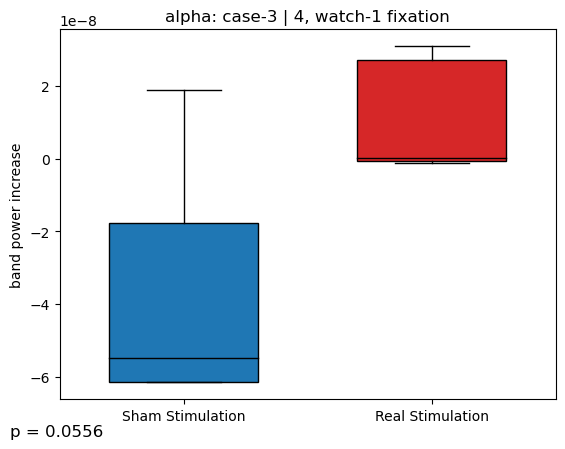

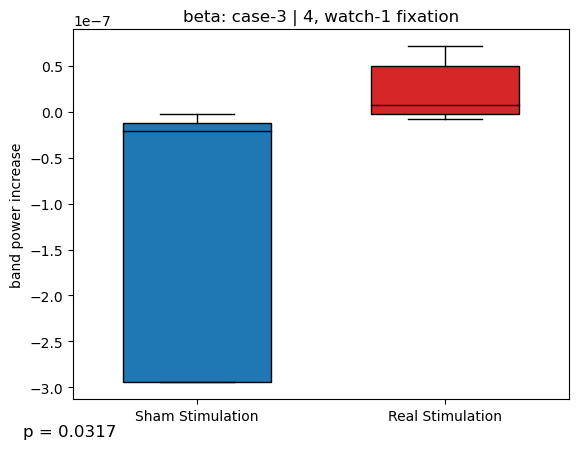

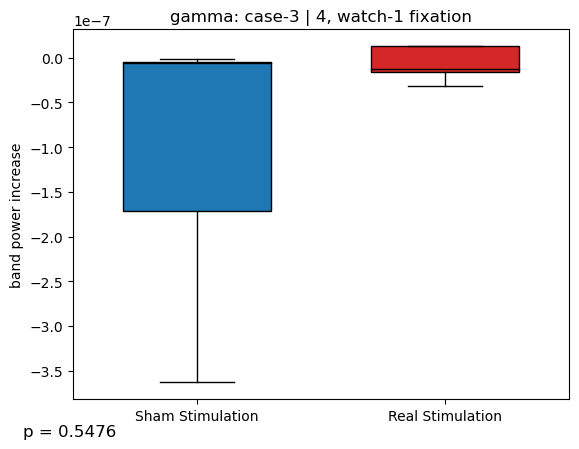

In [5]:
compare_objects = ['alpha', 'beta', 'gamma']
for compare_object in compare_objects:
    save_path = os.path.join('..', '..', '..', 'docs', 'report', 'figs', case+"_"+watch+"_"+compare_object+'.png')

    diff_sham = np.array(band_power.loc[band_power['band name'] == compare_object, 'sham increase'].apply(ast.literal_eval).values[0])
    diff_real = np.array(band_power.loc[band_power['band name'] == compare_object, 'real increase'].apply(ast.literal_eval).values[0])
    
    # create boxplot
    # Create a box plot with whiskers
    fig, ax = plt.subplots()
    boxplots = ax.boxplot([diff_sham, diff_real], patch_artist=True, widths=0.6, showfliers=False)

    # Set colors for the box plots
    colors = ['#1f77b4', '#d62728']
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)

    # Set median line color to black
    for median in boxplots['medians']:
        median.set_color('black')

    plt.xticks([1, 2], ['Sham Stimulation', 'Real Stimulation'])
    plt.ylabel('band power increase')
    plt.title(compare_object+": case-"+case+", watch-"+watch)

    # Perform the Mann-Whitney U test
    U, p_value = stats.mannwhitneyu(diff_sham, diff_real)

    # Add the p-value to the plot
    ax.annotate(f'p = {p_value:.4f}',
                xy=(-0.1, -0.1),
                xycoords=('axes fraction', 'axes fraction'),
                ha='left', fontsize=12)
    # plt.savefig(save_path, format='png')

    plt.show()